In [1]:
# import usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# our system imports
from aideme import *

%matplotlib inline

selectivity : 0.19733333333333333 %


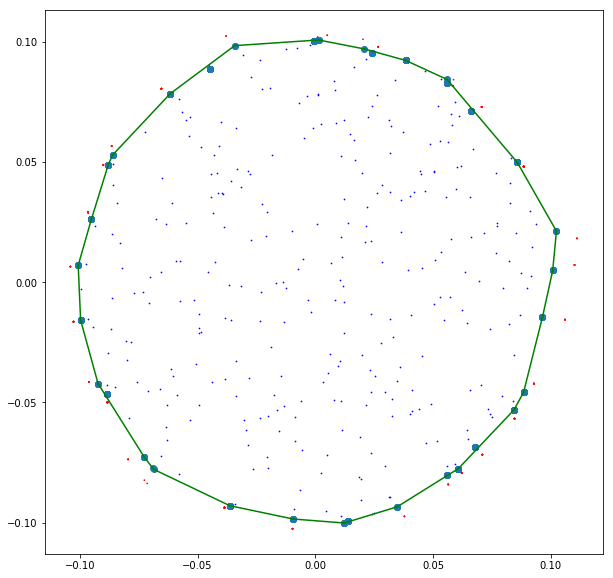

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import ConvexHull

# DUMMY DATA
N = int(150000)
dim = 2
limit = 2 * (0.001)**(1. / dim)
rng = np.random.RandomState(42)
X = rng.uniform(low=-2, high=2, size=(N, dim))  # do not forget to standardize the data. For this distribution, it should be fine without it.

# uncomment the data you want
# rectangle
# y_subspace = np.vstack([np.abs(X[:, i]) < limit for i in range(dim)]).T.astype('float')  # partial labels (for each subspace)
# y = y_subspace.min(axis=1)
# circle
y = (np.linalg.norm(X, axis=1) < 0.1) * 1.

index = None # -10 * np.arange(len(X))
#rectangle
# labeled_set = LabeledSet(y, y_subspace, index)
# circle
labeled_set = LabeledSet(y)

#negative points that we looked in boundary_point
negatives = []

# visualize data distribution
print('selectivity :', 100 * y.sum() / len(y), '%')

# plt.figure(figsize=(10,8))
# plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in y])
# plt.show()

def nearest(pos, X):
    """ 
    Returns the nearest point to pos in X
    """            
    i = np.argmin(np.linalg.norm(X - pos, axis=1))
    return X[i]

def boundary_point(pos, X, y, p=1/2):
    """
    Return the point in the decision border that will 
    be used in the margin evaluation of the point pos
    """
    neg = nearest(pos, X[y==0])
    pos2 = nearest(neg, X[y==1])
    negatives.append(neg) # for plot reasons
    
    return p * pos2 + (1 - p) * neg
        

def border(X, y, p=1/2):
    positives = X[y==1]
    b = np.empty(positives.shape)
    
    for i, pos in enumerate(positives):
        b[i] = boundary_point(pos, X, y, p).reshape(1,-1)
        
    return b

def margin(X, border):
    """
    Evaluates the margin of a set of points
    """
    # how about look for the distance to the convex hull?
#     b = border(X,y,p=0.5)
    distances = euclidean_distances(X, border)
    
    margin = distances.min(axis=1)
    return margin


def margin_single(point, border):
    return np.min(np.linalg.norm(point - border, axis=1))

b = border(X,y,p=0.5)
negatives = np.array(negatives)

hull = ConvexHull(b)

plt.figure(figsize=(10,10))
plt.plot(b[:,0], b[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(b[simplex, 0], b[simplex, 1], 'g')
plt.scatter(b[:, 0], b[:, 1], s=5, c='g')
plt.scatter(X[y==1, 0], X[y==1, 1], s=0.5, c='b')
plt.scatter(negatives[:, 0], negatives[:, 1], s=0.5, c=['r']*int(negatives.shape[0]))
plt.show()    

(500, 500)


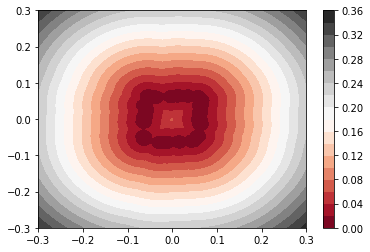

In [13]:
positives = X[y==1]
# np.argsort(np.linalg.norm(positives, axis=1))

m = margin(positives, b)

# plt.hist(m, bins=20)
xb = yb = np.linspace(-0.3, 0.3, 500)
xx, yy = np.meshgrid(xb, yb)
set_ = np.empty((len(xb)**2, b.shape[1])) # quantité des points, dimension 
for i in range(len(xb)**2):
    set_[i] = np.array([xx[int(i/len(xb))][i%len(xb)],yy[int(i/len(xb))][i%len(xb)]])
    
m = margin(set_, b)
m = m.reshape(len(xb), len(yb))
# for i in range(int(len(xb))):
#     for j in range(int(len(xb))):
#         print(round(m[i][j],2), end='\t')
#     print('\n')
# plt.contour(xx, yy, m, colors='black')
plt.contourf(xx, yy, m, 20, cmap='RdGy')
plt.colorbar()
# print(xb.shape)
# print(yy.shape)
print(m.shape)

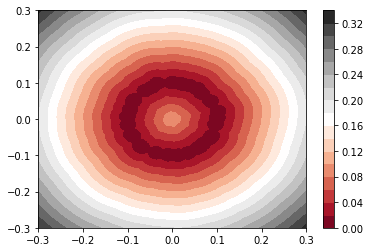

In [16]:
positives = X[y==1]
# np.argsort(np.linalg.norm(positives, axis=1))
negatives = []
# plt.hist(m, bins=20)
xb = yb = np.linspace(-0.3, 0.3, 500)
xx, yy = np.meshgrid(xb, yb)
set_ = np.empty((len(xb)**2, b.shape[1])) # quantité des points, dimension 
for i in range(len(xb)**2):
    set_[i] = np.array([xx[int(i/len(xb))][i%len(xb)],yy[int(i/len(xb))][i%len(xb)]])

m = margin(set_, b)
m = m.reshape(len(xb), len(yb))
plt.contourf(xx, yy, m, 20, cmap='RdGy')
plt.colorbar()


In [17]:
#activate cython 
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [36]:
%%cython
import numpy as np 
cimport numpy as np 
cdef double dist(double[::1] x, double[::1] y):
    cdef double dist=0
    cdef unsigned int i=0
    cdef int dim=len(x)
    for i in range(dim):
        dist+=(x[i]-y[i])*(x[i]-y[i])
    return dist
    
def min_distances(double[:,::1] A, double[:,::1] B):
    cdef:
        int[::1] arg_pos = np.empty(A.shape[0],dtype=np.int32)
        double[::1] dists= np.empty(A.shape[0],dtype='float')
        int i, j
        int lenA=A.shape[0], lenB=B.shape[0] 
        double d, d_min
        
    for i in range(lenA):
        d_min = 1e5
        for j in range(lenB):
            d = dist(A[i],B[i])
            if d < d_min:
                d_min = d
                arg_pos[i] = j
        dists[i] = d_min
    return  dists, arg_pos


In [37]:
def margin_negatives(X, y): 
    """
    Return the margin of negatives points 
    and the 'nearest' positives calculated in the process 
    """
    negatives = X[y==0]
    positives = X[y==1]
    
    return min_distances(negatives, positives)
#     distances = euclidean_distances(negatives, positives)
#     margin = distances.min(axis=1)######################
#     arg_pos = np.argmin(distances, axis=1)
    
#     return margin, arg_pos
    
def margin_positives(arg_pos, X, y, p=1/2):
    negatives = X[y==0]
    negatives = negatives[np.argmin(euclidean_distances(X[arg_pos], negatives), axis=1)]
    margin = euclidean_distances(X[y==1], negatives).min(axis=1)
    
    return margin

def margin2(X,y):
    margin_neg, arg_pos= margin_negatives(X, y)
    margin_pos = margin_positives(arg_pos, X, y)
    
    return np.concatenate(margin_neg, margin_pos)

In [38]:
xb = yb = np.linspace(-0.3, 0.3, 500)
xx, yy = np.meshgrid(xb, yb)
set_ = np.empty((len(xb)**2, b.shape[1])) # quantité des points du meshgrid, dimension 
for i in range(len(xb)**2):
    set_[i] = np.array([xx[int(i/len(xb))][i%len(xb)],yy[int(i/len(xb))][i%len(xb)]])
    
y_ = (np.linalg.norm(set_, axis=1) < 0.2) * 1.

m = margin2(set_, y_)
m = m.reshape(len(xb), len(yb))
plt.contourf(xx, yy, m, 20, cmap='RdGy')
plt.colorbar()

IndexError: Index out of bounds (axis 0)

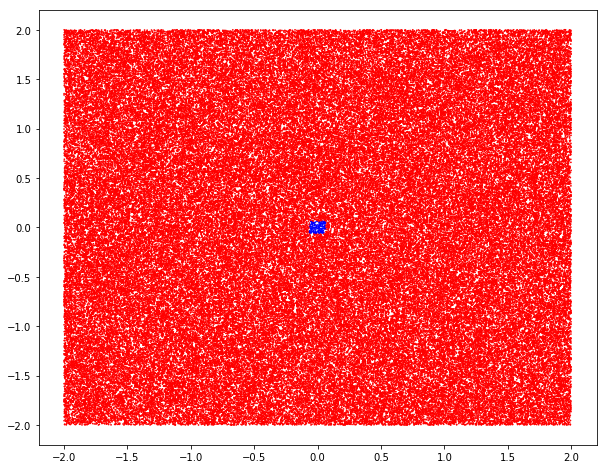

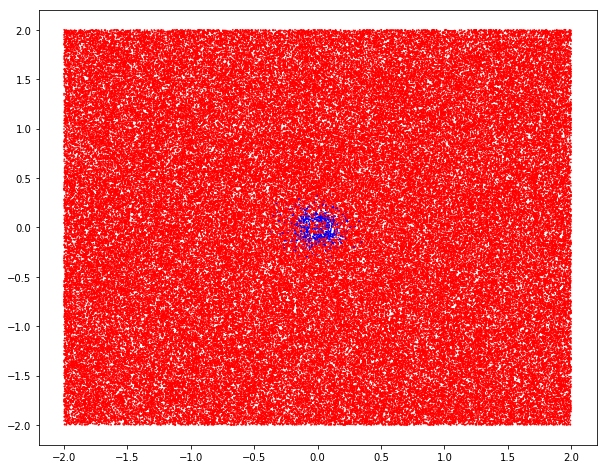

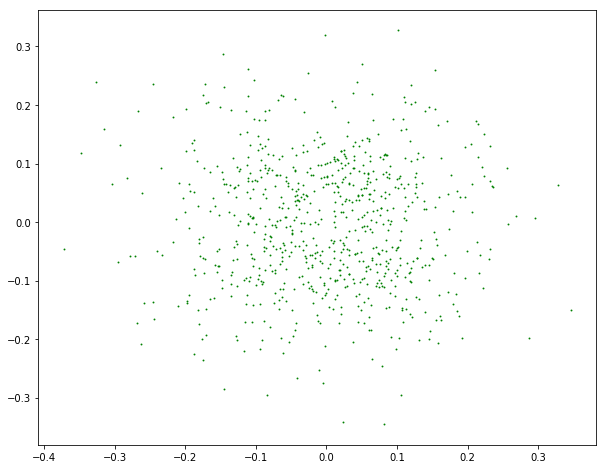

In [13]:
from scipy.stats import norm
def noised_samples(X, y, border, loc=0, scale=1, epsilon=0.0001):
    m = margin(X, border) + epsilon
    probs = 2 - 2 * norm.cdf(m, loc, scale)
    
    changes = np.random.binomial(1, probs) 
    new_labels = np.logical_xor(y,changes) * 1
    
    return new_labels, changes

nl, changes = noised_samples(X, y, b, scale=0.1)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in y])
plt.show()
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in nl])
plt.show()
Xchanged = X[changes==1]
plt.figure(figsize=(10,8))
plt.scatter(Xchanged[:, 0], Xchanged[:, 1], s=0.8, c='g')
plt.show()

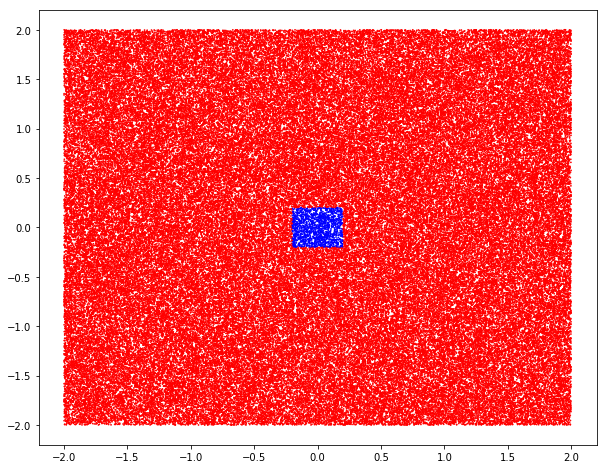

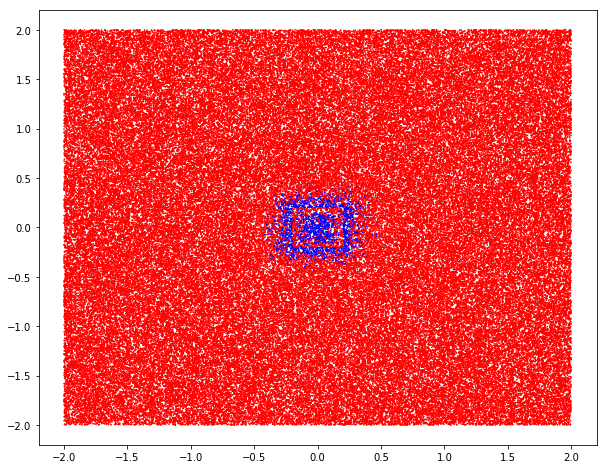

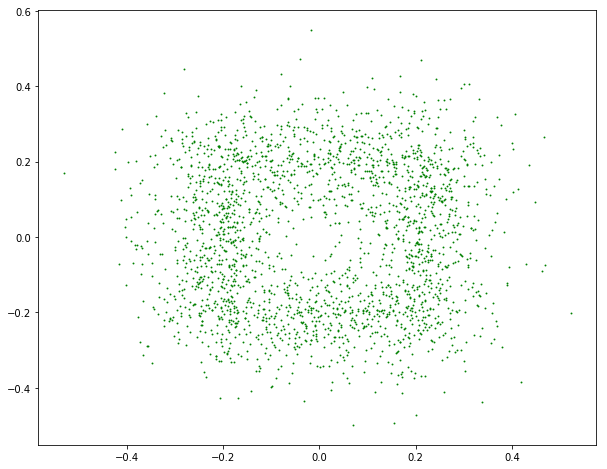

In [17]:
from scipy.stats import norm
def noised_samples(X, y, border, loc=0, scale=1, epsilon=0.0001):
    m = margin(X, border) + epsilon
    probs = 2 - 2 * norm.cdf(m, loc, scale)
    
    changes = np.random.binomial(1, probs) 
    new_labels = np.logical_xor(y,changes) * 1
    
    return new_labels, changes

nl, changes = noised_samples(X, y, b, scale=0.1)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in y])
plt.show()
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in nl])
plt.show()
Xchanged = X[changes==1]
plt.figure(figsize=(10,8))
plt.scatter(Xchanged[:, 0], Xchanged[:, 1], s=0.8, c='g')
plt.show()

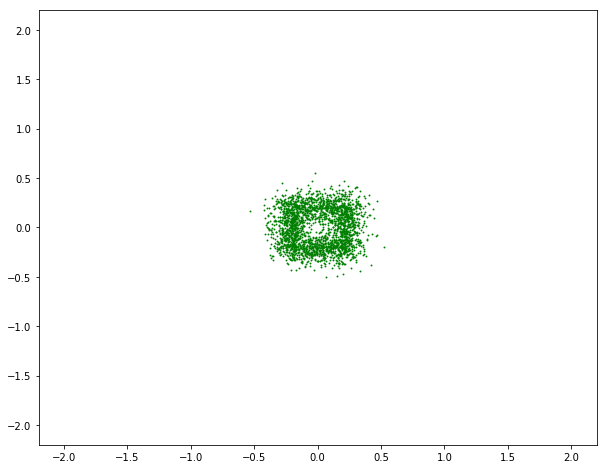

In [22]:
plt.figure(figsize=(10,8))
plt.scatter(Xchanged[:, 0], Xchanged[:, 1], s=0.8, c='g')
plt.scatter([2,0]+[-2,0], [2,0]+[-2,0], s=0.8, c='w')
plt.show()

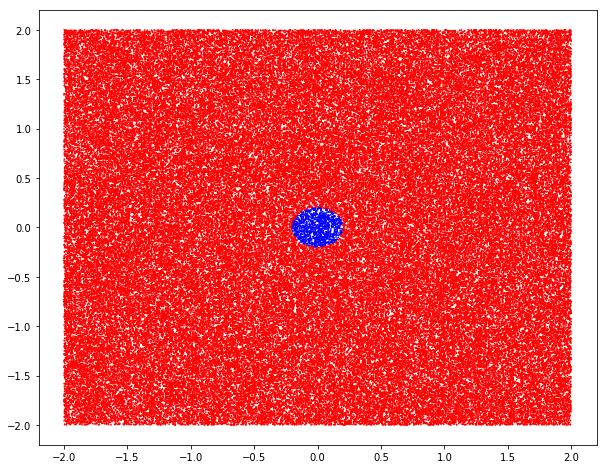

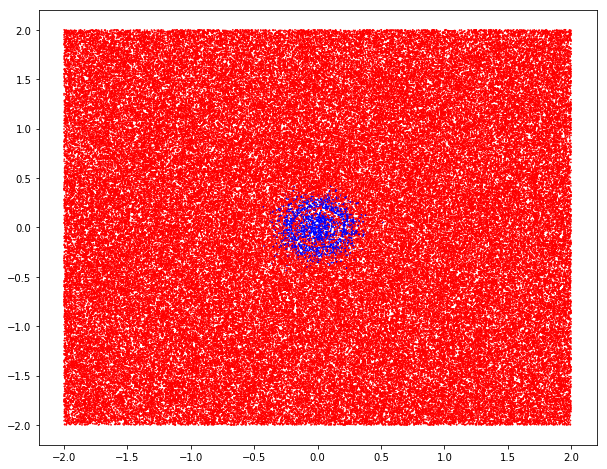

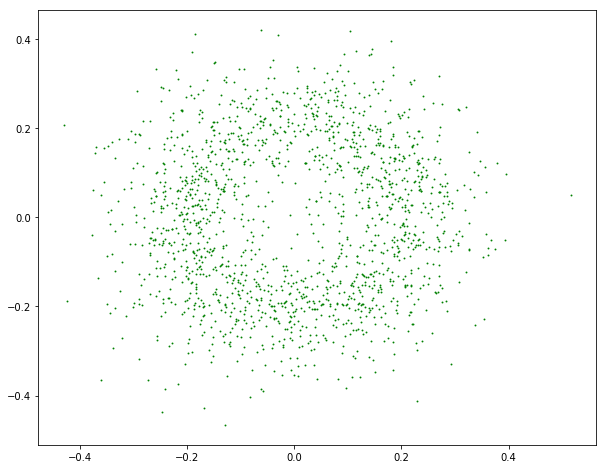

In [8]:
from scipy.stats import norm
def noised_samples(X, y, border, loc=0, scale=1, epsilon=0.01):
    m = margin(X, border) + epsilon
    probs = 2 - 2 * norm.cdf(m, loc, scale)
    
    changes = np.random.binomial(1, probs) 
    new_labels = np.logical_xor(y,changes) * 1
    
    return new_labels, changes

nl, changes = noised_samples(X, y, b, scale=0.1)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in y])
plt.show()
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in nl])
plt.show()
Xchanged = X[changes==1]
plt.figure(figsize=(10,8))
plt.scatter(Xchanged[:, 0], Xchanged[:, 1], s=0.8, c='g')
plt.show()

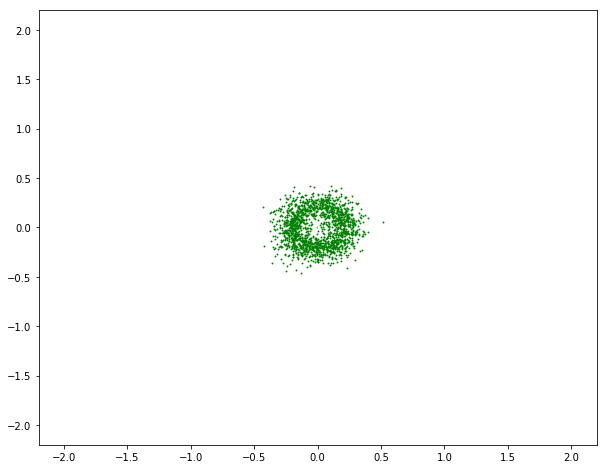

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(Xchanged[:, 0], Xchanged[:, 1], s=0.8, c='g')
plt.scatter([2,0]+[-2,0], [2,0]+[-2,0], s=0.8, c='w')
plt.show()